# AtariSpace

This task will not "play" atari but rather simply explore it. That is, there are no rewards, just a (nearly) passive viewing of the different games. The network can take actions within a game, or can cycle between the list of games, but is not rewarded by game score. Instead the network simply watches the games and tries to predict future frames. 

## VNet
This "visual" network is simply an autoencoder. The bottleneck layer is treated as a latent variable (LV). It is convolutional with tied encoder-decoder weights. 

## HNet
This "hippocampal" network takes in the current LV and tries to predict the next LV. This assumes that VNet is relatively constant (low learning rate or frozen). This should have a high LR, and use memory augmentation to preserve long-term dependencies.

## MNet
A small "motor"  network will be trained to maximize prediction errors as a method to encourage exploration. Prediction error is a positive scalar and there is an ideal "Goldilocks zone" for exploration which we approximate with an Erlang distribution.
This could just be random actions, but if any useful exploration policies are learned then great. 

## Environment notes
Any input from any game is allowed (0-17), and ideally MNet should learn which inputs are actually useful in a given game. Two more inputs will allow for cycling between games.

In [1]:
import gymnasium as gym
import math
import random, datetime, os, copy, time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

/export03/data/opt/venv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
possible_actions = 17 # possible actions in all games (inc 0)
games = ['ALE/Tetris-v5', 'ALE/Adventure-v5', 'ALE/AirRaid-v5', 'ALE/Alien-v5', 'ALE/Amidar-v5', 'ALE/Assault-v5', 'ALE/Asterix-v5', 
         'ALE/Asteroids-v5', 'ALE/Atlantis-v5', 'ALE/Atlantis2-v5', 'ALE/Backgammon-v5', 'ALE/BankHeist-v5', 'ALE/BasicMath-v5', 
         'ALE/BattleZone-v5', 'ALE/BeamRider-v5', 'ALE/Berzerk-v5', 'ALE/Blackjack-v5', 'ALE/Bowling-v5', 'ALE/Boxing-v5', 'ALE/Breakout-v5', 
         'ALE/Carnival-v5', 'ALE/Casino-v5', 'ALE/Centipede-v5', 'ALE/ChopperCommand-v5', 'ALE/CrazyClimber-v5', 'ALE/Crossbow-v5', 
         'ALE/Darkchambers-v5', 'ALE/Defender-v5', 'ALE/DemonAttack-v5', 'ALE/DonkeyKong-v5', 'ALE/DoubleDunk-v5', 'ALE/Earthworld-v5', 
         'ALE/ElevatorAction-v5', 'ALE/Enduro-v5', 'ALE/Entombed-v5', 'ALE/Et-v5', 'ALE/FishingDerby-v5', 'ALE/FlagCapture-v5', 
         'ALE/Freeway-v5', 'ALE/Frogger-v5', 'ALE/Frostbite-v5', 'ALE/Galaxian-v5', 'ALE/Gopher-v5', 'ALE/Gravitar-v5', 'ALE/Hangman-v5', ]
         # 'ALE/HauntedHouse-v5', 'ALE/Hero-v5', 'ALE/HumanCannonball-v5', 'ALE/IceHockey-v5', 'ALE/Jamesbond-v5', 'ALE/JourneyEscape-v5', 
         # 'ALE/Kaboom-v5', 'ALE/Kangaroo-v5', 'ALE/KeystoneKapers-v5', 'ALE/KingKong-v5', 'ALE/Klax-v5', 'ALE/Koolaid-v5', 'ALE/Krull-v5', 
         # 'ALE/KungFuMaster-v5', 'ALE/LaserGates-v5', 'ALE/LostLuggage-v5', 'ALE/MarioBros-v5', 'ALE/MiniatureGolf-v5', 'ALE/MontezumaRevenge-v5', 
         # 'ALE/MrDo-v5', 'ALE/MsPacman-v5', 'ALE/NameThisGame-v5', 'ALE/Othello-v5', 'ALE/Pacman-v5', 'ALE/Phoenix-v5', 'ALE/Pitfall-v5', 
         # 'ALE/Pitfall2-v5', 'ALE/Pong-v5', 'ALE/Pooyan-v5', 'ALE/PrivateEye-v5', 'ALE/Qbert-v5', 'ALE/Riverraid-v5', 'ALE/RoadRunner-v5', 
         # 'ALE/Robotank-v5', 'ALE/Seaquest-v5', 'ALE/SirLancelot-v5', 'ALE/Skiing-v5', 'ALE/Solaris-v5', 'ALE/SpaceInvaders-v5', 
         # 'ALE/SpaceWar-v5', 'ALE/StarGunner-v5', 'ALE/Superman-v5', 'ALE/Surround-v5', 'ALE/Tennis-v5', 
         # 'ALE/TimePilot-v5', 'ALE/Trondead-v5', 'ALE/Turmoil-v5', 'ALE/Tutankham-v5', 'ALE/UpNDown-v5', 'ALE/Venture-v5', 'ALE/VideoCheckers-v5', 
         # 'ALE/VideoPinball-v5', 'ALE/WizardOfWor-v5', 'ALE/WordZapper-v5', 'ALE/YarsRevenge-v5', 'ALE/Zaxxon-v5']
g=0
def AtariSpace(action):
    global env,g
    if action==0:
        g = g-1
        if g<0:
            g=len(games)-1
        env = gym.make(games[g], obs_type='grayscale', 
                       render_mode='rgb_array', 
                       full_action_space=True)
        frame = env.reset()[0]
    elif action==1:
        g = g+1
        if g>len(games)-1:
            g=0
        env = gym.make(games[g], obs_type='grayscale', 
                       render_mode='rgb_array', 
                       full_action_space=True)
        frame = env.reset()[0]
    else:
        frame = env.step(action-2)[0]
    if np.max(frame)==0: # some games have a blank frame
        frame = env.step(0)[0]
    return frame

In [3]:
# utilities
current_frame = torch.zeros((241,153)).to(device)
def frameproc(frame):
    global current_frame
    # trim, resize to suit our convolutions, and standardize
    # frame = frame[25:225,:]
    frame = np.expand_dims(np.expand_dims(frame, 0), 0)
    frame = torch.as_tensor(frame, dtype=torch.float32)
    means = frame.mean()
    stds = frame.std()
    frame = (frame - means) / (stds+1e-06)
    frame = torchvision.transforms.Resize((241,153))(frame)
    current_frame = frame.to(device)
    return

def live_plot(imgs):
    clear_output(wait=True)
    for p in range(len(imgs)):
        plt.subplot(1,len(imgs),p+1)
        if current_frame.dtype==torch.float32:
            plt.imshow(torch.squeeze(imgs[p]).to('cpu').detach())
        else:
            plt.imshow(imgs[p])
        plt.axis('off')
    plt.show();

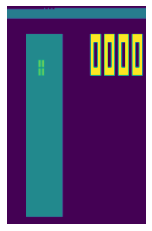

torch.Size([1, 1, 241, 153])
torch.Size([1, 1, 241, 153])


In [4]:
# Test out environment and utilities!
for s in [1,1,2,1,1,1,0,0,0,2,0,0]:
    frame = AtariSpace(s)
    origshape = current_frame.shape
    frameproc(frame)
    live_plot([current_frame])
    time.sleep(0.25)
print(origshape)
print(current_frame.shape)

In [5]:
# conv2d design testing
# ideally out convolutions should work with the input image size to only produce integers here. This will help a lot in the ConvTranspose2d decoder!
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1
    w = ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1
    return h, w
t1 = conv_output_shape(current_frame.shape[2:4],kernel_size=5, stride=2)
t2 = conv_output_shape(t1,kernel_size=3, stride=2)
t3 = conv_output_shape(t2,kernel_size=3, stride=2)
print(t1)
print(t2)
print(t3)
flatsz = int(np.prod(t3)*32)
print(flatsz)

(119.0, 75.0)
(59.0, 37.0)
(29.0, 18.0)
16704


In [6]:
class VNet(nn.Module):
    #This will be a convolutional AE with tied encoder-decoder weights. Encoder can optionally be frozen.

    def __init__(self, output_dim=(512)):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2),
            nn.Tanh(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.Tanh(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(flatsz, 10000, bias=False),
            nn.Tanh(),
            nn.Linear(10000, output_dim, bias=False),
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, 10000, bias=False),
            nn.Tanh(),
            nn.Linear(10000,flatsz,bias=False),
            nn.Tanh(),
            # nn.Unflatten(1,(1,241,153)),
            nn.Unflatten(1,(32,int(t3[0]),int(t3[1]))),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5, stride=2),
        )
            
        # tie the weights
        for i in range(len(self.encoder)):
            ii = len(self.encoder)-i-1
            if hasattr(self.encoder[i],'weight'):
                if len(self.encoder[i].weight.shape)>2:
                    self.decoder[ii].weight = nn.Parameter(self.encoder[i].weight)
                else:
                    self.decoder[ii].weight = nn.Parameter(self.encoder[i].weight.t())

        # frozen versions
        self.encoderfrozen = copy.deepcopy(self.encoder)
        for p in self.encoderfrozen.parameters():
            p.requires_grad = False
        self.decoderfrozen = copy.deepcopy(self.decoder)
        for p in self.decoderfrozen.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.encoder(input)
        elif model == "frozen":
            return self.encoderfrozen(input)
        
    def backward(self, input, model):
        if model == "online":
            return self.decoder(input)
        elif model == "frozen":
            return self.decoderfrozen(input)
vnet = VNet().to(device)
print(vnet)

VNet(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): Tanh()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): Tanh()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=16704, out_features=10000, bias=False)
    (8): Tanh()
    (9): Linear(in_features=10000, out_features=512, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=10000, bias=False)
    (1): Tanh()
    (2): Linear(in_features=10000, out_features=16704, bias=False)
    (3): Tanh()
    (4): Unflatten(dim=1, unflattened_size=(32, 29, 18))
    (5): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): Tanh()
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (8): Tanh()
    (9): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2))
  )
  (encoderfrozen): Sequential(
    (0): Conv2d(1, 16, kernel_size=

In [7]:
VLoss = nn.MSELoss()
VOptim = optim.Adam(vnet.parameters(), lr=1e-05, weight_decay=1e-08)

In [8]:
vnet.load_state_dict(torch.load('VNet_saved'))

<All keys matched successfully>

In [9]:
# quick test / pretrain of VNet

# log = []
# for i in range(100000):
#     frame = AtariSpace(1+possible_actions)
#     frameproc(frame)

#     next_LV = vnet.forward(current_frame, model='online')
#     recon_frame = vnet.backward(next_LV, model='online')

#     vloss = VLoss(recon_frame,current_frame)
#     log.append([vloss.to('cpu').detach()])
#     VOptim.zero_grad()
#     vloss.backward()
#     VOptim.step()
    
#     if i%100==0:
#         live_plot([current_frame,recon_frame.detach()])
#         print(f'iteration: {i}')
        
#     del next_LV,recon_frame,vloss,frame
    
# torch.save(vnet.state_dict(),'VNet_saved')

In [10]:
from dnc import DNC

hnet = DNC(
  input_size=515,
  hidden_size=512,
  rnn_type='lstm',
  num_layers=1,
  nr_cells=100,
  cell_size=32,
  read_heads=4,
  batch_first=True,
  gpu_id=0,
)

(controller_hidden, memory, read_vectors) = (None, None, None)

output, (controller_hidden, memory, read_vectors) = \
  hnet(torch.randn(1, 1, 515).to(device), (controller_hidden, memory, read_vectors), reset_experience=True)
print(hnet)


----------------------------------------
DNC(515, 512, nr_cells=100, read_heads=4, cell_size=32, gpu_id=0)
DNC(
  (lstm_layer_0): LSTM(643, 512, num_layers=2, batch_first=True)
  (rnn_layer_memory_shared): Memory(
    (interface_weights): Linear(in_features=512, out_features=247, bias=True)
  )
  (output): Linear(in_features=640, out_features=515, bias=True)
)
----------------------------------------



In [11]:
HLoss = nn.MSELoss()
HOptim = optim.SGD(hnet.parameters(),lr=1e-05, weight_decay=1e-05)

In [12]:
hnet.load_state_dict(torch.load('HNet_saved'))

<All keys matched successfully>

In [13]:
# https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63

class MNet(nn.Module):
    # simple fully connected with softmax at the end; optionally frozen
    
    def __init__(self, input_dim=(512), output_dim=(3)):
        super().__init__()
        self.online = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.ReLU(),
            nn.Softmax(),
        )

        self.frozen = copy.deepcopy(self.online)
        for p in self.frozen.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "frozen":
            return self.frozen(input)
        
    def get_action(self, input, model):
        probs = self.forward(input, model)
        highest_prob_action = np.random.choice(3, p=np.squeeze(probs.cpu().detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
        return highest_prob_action, log_prob, probs
        
mnet = MNet().to(device)
print(mnet)

MNet(
  (online): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
    (3): ReLU()
    (4): Softmax(dim=None)
  )
  (frozen): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
    (3): ReLU()
    (4): Softmax(dim=None)
  )
)


In [14]:
# m=0
# def erlang(x,k=4,l=4):
#     return ((l**k)*(x**(k-1))*(math.e**(-l*x)))/math.factorial(k-1)*2 -1.4
# x = np.linspace(0,5,num=50)
# plt.plot(x,erlang(x))
# plt.title("Goldilocks novelty zone")
# plt.xlabel("novelty (prediction error)")
# plt.ylabel("motor policy loss")

GAMMA = 0.9
MOptim = optim.Adam(mnet.parameters(), lr=1e-05)

def update_policy(MNet, rewards, log_probs):
    discounted_rewards = []
    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
    # discounted_rewards = torch.tensor(discounted_rewards)
    # discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    MOptim.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    MOptim.step()

In [15]:
mnet.load_state_dict(torch.load('MNet_saved'))

<All keys matched successfully>

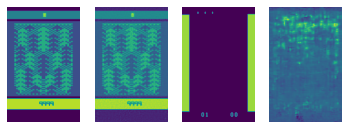

9999
3480.6133284568787


In [16]:
# initialize state
g = np.random.randint(0,len(games))
frame = AtariSpace(0)
frameproc(frame)
current_LV = vnet.forward(current_frame, model='frozen')
log_probs = []
rewards = []
# the complicated part.
# 0) reconstruct the frame from the current LV (just for viewing)
# 1a) choose next action from the current LV
# 1b) make a prediction from the current LV about the next LV
# 1c) reconstruct the next frame from the predicted LV
# 2) take the action and get the actual next frame+LV
# 3a) train VNet to reconstruct the current frame from the current LV
# 3b) train HNet to predict next LV from the current LV
# 3c) train MNet to maximize HLoss
log = []
t = time.time()
for i in range(10000):
    
    current_action, log_prob, probs = mnet.get_action(current_LV.detach(), model='online')
    # x = torch.cat((current_LV.detach(), current_action.detach()),dim=1)[None,:]
    x = torch.cat((current_LV, probs.detach()),dim=1)[None,:]
    predicted_LV,_ = hnet(x)
    recon_frame = vnet.backward(current_LV.detach(), model='online')
    predicted_frame = vnet.backward(predicted_LV[:,0,:512].detach(), model='online')
    
    vloss = VLoss(recon_frame,current_frame)
    VOptim.zero_grad()
    vloss.backward()
    VOptim.step()
    
    old_frame = copy.deepcopy(current_frame.detach())
    frame = AtariSpace(current_action)
    frameproc(frame)
    next_LV = vnet.forward(current_frame.detach(), model='online')
    if i%1==0:
        live_plot([old_frame,recon_frame,current_frame,predicted_frame])
        print(i)
   
    y = torch.cat((next_LV.detach(), probs.detach()),dim=1)
    y = y[None,:]
    hloss = HLoss(predicted_LV,y)
    HOptim.zero_grad()
    hloss.backward()
    HOptim.step()
    
    log_probs.append(log_prob)
    rewards.append(hloss.detach() + vloss.detach())
    if i%20==19:
        update_policy(MNet, rewards, log_probs)
        log_probs = []
        rewards = []
    
    log.append([vloss.to('cpu').detach(), hloss.to('cpu').detach(), log_prob.to('cpu').detach(), g])
    current_LV = next_LV
    # del predicted_LV, recon_frame, predicted_frame, next_LV, hloss, vloss, x, y

elapsed = time.time() - t
print(elapsed)

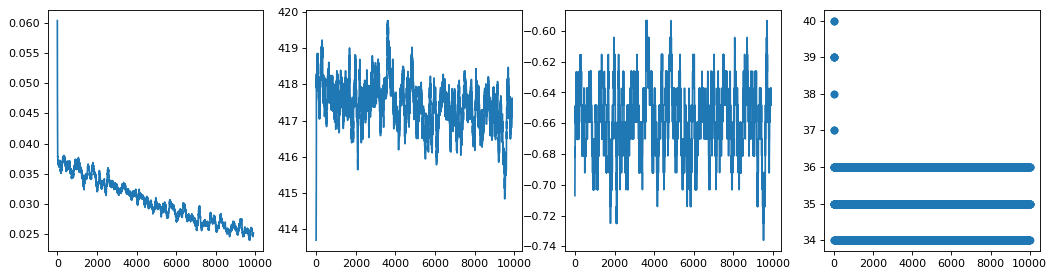

In [17]:
plt.figure(figsize=(16, 4), dpi=80)
log = np.asarray(log)
plt.subplot(1,4,1)
plt.plot(np.convolve(np.array(log)[:,0],np.ones(100)/100, mode='valid'))
plt.subplot(1,4,2)
plt.plot(np.convolve(np.array(log)[:,1],np.ones(100)/100, mode='valid'))
plt.subplot(1,4,3)
plt.plot(np.convolve(np.array(log)[:,2],np.ones(100)/100, mode='valid'))
plt.subplot(1,4,4)
plt.scatter(range(len(log)),log[:,3])

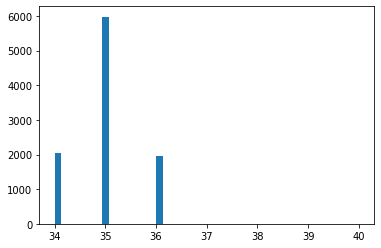

In [18]:
plt.hist(log[:,3], bins=len(games));

In [19]:
torch.save(vnet.state_dict(),'VNet_saved')
torch.save(hnet.state_dict(),'HNet_saved')
torch.save(mnet.state_dict(),'MNet_saved')

## Let's query the HNet and see if we find cool stuff like place&grid cells

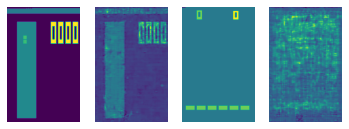

179
65.14316034317017


In [20]:
# initialize state
g = 0
frame = AtariSpace(0)
frameproc(frame)
current_LV = vnet.forward(current_frame, model='frozen')
log_probs = []
rewards = []
log = []
t = time.time()
for i in range(len(games)*4):
    
    # current_action, log_prob, probs = mnet.get_action(current_LV.detach(), model='online')
    current_action, probs = 0, torch.tensor(np.reshape([1,0,0],(1,3))).to('cuda')
    x = torch.cat((current_LV, probs),dim=1)[None,:]
    predicted_LV,(controller_hidden, memory, read_vectors) = hnet(x)
    recon_frame = vnet.backward(current_LV.detach(), model='online')
    predicted_frame = vnet.backward(predicted_LV[:,0,:512].detach(), model='online')
    
    
    old_frame = copy.deepcopy(current_frame.detach())
    frame = AtariSpace(current_action)
    frameproc(frame)
    next_LV = vnet.forward(current_frame.detach(), model='online')
    if i%1==0:
        live_plot([old_frame,recon_frame,current_frame,predicted_frame])
        print(i)
   
    
    log.append(controller_hidden)
    current_LV = next_LV
    # del predicted_LV, recon_frame, predicted_frame, next_LV, hloss, vloss, x, y

elapsed = time.time() - t
print(elapsed)

In [21]:
arr = np.zeros((len(log),2,512))
for i in range(len(log)):
    arr[i,:,:] = np.squeeze(log[i][0][0].detach().cpu().numpy())

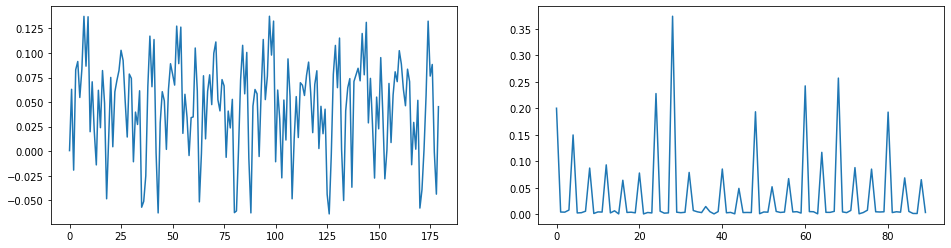

In [22]:
# https://dsp.stackexchange.com/questions/8830/how-do-i-determine-if-a-discrete-signal-is-periodic-or-not
# array to fft
from scipy.fft import fft, fftfreq
i=1
hl=0

yf = fft(arr[:,hl,i])
yf = 2.0/len(log) * np.abs(yf[0:len(log)//2])
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
ax[0].plot(arr[:,1,i]);
ax[1].plot(yf);

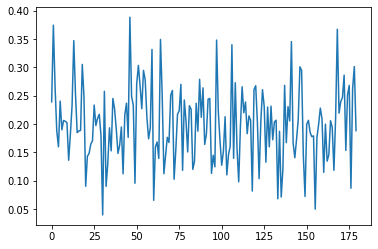

In [23]:
#find the max peaks in the fft
minlen=10

ma = np.zeros((len(log)))
for i in range(len(log)):
    yf = fft(arr[:,hl,i])
    yf = 2.0/len(log) * np.abs(yf[0:len(log)//2])
    ma[i] = np.max(yf[minlen:])
plt.plot(ma)

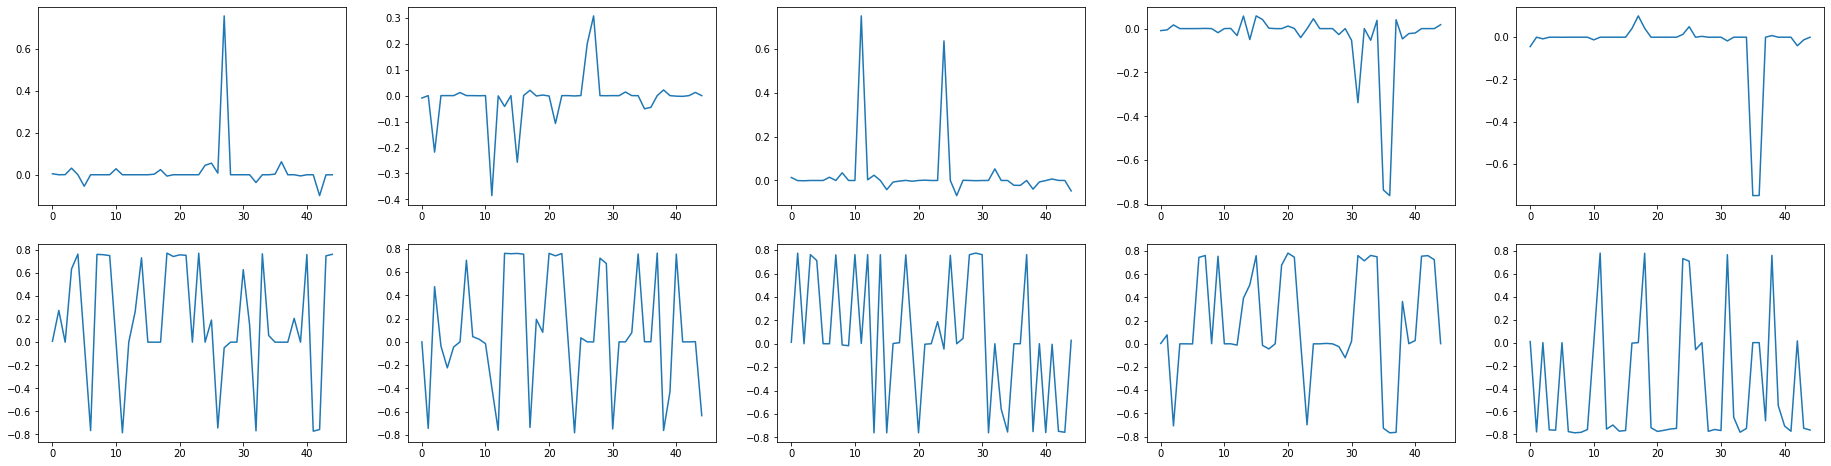

In [24]:
# plot top 5 peaks and lowest 5 peaks
fig,ax = plt.subplots(nrows=2, ncols=5, figsize=(32,8))
mai = np.argsort(ma)
for i in range(5):
    ax[0,i].plot(arr[:len(games),hl,mai[i]])
    ax[1,i].plot(arr[:len(games),hl,mai[-(i+1)]])